### Importamos librerias 

In [1]:
import numpy as np
import random


import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from sklearn import linear_model
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

### Feature Selection con GA y DEAP

**Contenido:**

1. Generación del dataset y creación de la función de evaluación.
2. Instanciación del toolbox de DEAP y configuración del problema y los operadores.
3. Generación de un Algoritmo Genético Simple codeado por nosotros.

![](../images/deap_logo.png)

###  1. Generación del dataset y creación de la función de evaluación.

#### Generamos el dateset y definimos el modelo a utilizar 

In [2]:
# Definimos la cantidad de features a utilizar
n_features = 15

# Seteamos verbose en false
verbose = 0

In [3]:
# Inicialmente lo que haremos es generar el dataset
X, y = make_classification(n_samples=1000, n_features=n_features, n_classes=2, n_informative=4, 
                           n_redundant=1, n_repeated=2, random_state=1)

In [4]:
# Luego defineremos el modelo a utilizar
model = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')

#### Creamos las funciones auxiliares para realizar la evaluacion 

In [5]:
# Por ultimo generaremos las funciones de evaluacion
def calculate_fitness(model, x, y):
    cv_set = np.repeat(-1.0, x.shape[0])
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if x_train.shape[0] != y_train.shape[0]:
            raise Exception()
        model.fit(x_train, y_train)
        predicted_y = model.predict(x_test)
        cv_set[test_index] = predicted_y
    return f1_score(y,cv_set)

In [6]:
def evaluate(individual):
    np_ind = np.asarray(individual)
    if np.sum(np_ind) == 0:
        fitness = 0.0
    else:
        feature_idx = np.where(np_ind == 1)[0]
        fitness = calculate_fitness(
            model, X[:, feature_idx], y
        )
        if verbose:
            print("Individuo: {}  Fitness Score: {} ".format(individual, fitness))

    return (fitness,)

### 2.  Instanciación del toolbox de DEAP y configuración del problema y los operadores.

#### Definimos el tipo de problema e instanciamos el Toolbox 

In [7]:
# En primer lugar definimos si es un problema de maximización o minimización
# Esto sea seteando los pesos en "1.0"
creator.create("FeatureSelect", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FeatureSelect)

toolbox = base.Toolbox()

#### Configuramos a nuestro individuo y a nuestra poblacion 

In [8]:
# Definimos como estara conformado nuestro inviduo
# En nuestro caso sera un vector de 0 y 1
toolbox.register("attr_bool", random.randint, 0, 1)

# Luego definimos que nuestro inviduo ademas tendra la longitud = n_features
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)

# Configuramos a nuestra poblacion, indicando como son los individuos que la conformaran
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

**Recursos:**  
Para más información revisar la documentación de **[DEAP](https://deap.readthedocs.io/en/master/)**.

#### Definimos los operadores 

![](../images/ga_operators.png)

In [9]:
toolbox.register("mate", tools.cxTwoPoint) # Crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1) # Mutacion
toolbox.register("select", tools.selTournament, tournsize=3) # Selecion
toolbox.register("evaluate", evaluate) # Evaluacion

**Recursos:**  
Por cada operador existen diferentes variantes. Para ver cuáles están disponibles revisar la documentación de **[DEAP](https://deap.readthedocs.io/en/master/api/tools.html#operators)**.

### 3. Generación de un Algoritmo Genético Simple codeado por nosotros. 

#### Definimos algunas constantes y desarrollamos un funcion auxiliear para visualizar las estadisticas 

In [10]:
N_POP = 100 # Tamaño de la población
CXPB = 0.5 # Probabilidad de crossover
MUTPB = 0.2 # Probabilidad de mutación
NGEN = 10 # Cantidad de generaciones

In [11]:
print(
    "Tamaño población: {}\nProbabilidad de crossover: {}\nProbabilida de mutación: {}\nGeneraciones totales: {}".format(
        N_POP, CXPB, MUTPB, NGEN
    )
)

Tamaño población: 100
Probabilidad de crossover: 0.5
Probabilida de mutación: 0.2
Generaciones totales: 10


In [12]:
# Función para generar reporte custom
def build_stats(gen, pop, fits):
    record = {}
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5
    
    record['gen'] = gen + 1
    record['min'] = min(fits)
    record['max'] = max(fits)
    record['avg'] = mean
    record['std'] = std
    
    print("  Min {}  Max {}  Avg {}  Std {}".format(min(fits), max(fits), mean, std))

    return record

#### Algoritmo Genetico

In [13]:
# Inicializamos a la poblacion
pop = toolbox.population(N_POP)

In [14]:
print("Evaluamos a los indivudos inicializados.......")
fitnesses = list(map(toolbox.evaluate, pop))

Evaluamos a los indivudos inicializados.......


In [15]:
# Asignamos a los inviduos el score del paso anterior
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [16]:
fitness_in_generation = {} # Variable auxiliar para generar el reporte
stats_records = [] # Variable auxiliar para generar el reporte

print("-- GENERACIÓN 0 --")
stats_records.append(build_stats(-1, pop, fitnesses[0]))

for g in range(NGEN):
    print("-- GENERACIÓN {} --".format(g + 1))
    # Seleccionamos a la siguiente generacion de individuos
    offspring = toolbox.select(pop, len(pop))
    
    # Clonamos a los invidiuos seleccionados
    offspring = list(map(toolbox.clone, offspring))

    # Aplicamos crossover y mutacion a los inviduos seleccionados
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    
    # Evaluamos a los individuos con una fitness invalida
    weak_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, weak_ind))
    for ind, fit in zip(weak_ind, fitnesses):
        ind.fitness.values = fit
    print("Individuos evaluados: {}".format(len(weak_ind)))

    # Reemplazamos a la poblacion completamente por los nuevos descendientes
    pop[:] = offspring
    
    # Mostramos las salidas de la estadisticas de la generacion actual
    fits = [ind.fitness.values[0] for ind in pop]
    
    stats_records.append(build_stats(g, pop, fits))

-- GENERACIÓN 0 --
  Min 0.7852882703777336  Max 0.7852882703777336  Avg 0.007852882703777337  Std 0.07813519635330315
-- GENERACIÓN 1 --
Individuos evaluados: 75
  Min 0.612668743509865  Max 0.8078431372549019  Avg 0.7844941651526885  Std 0.02662700586534695
-- GENERACIÓN 2 --
Individuos evaluados: 58
  Min 0.6517766497461929  Max 0.8078431372549019  Avg 0.7906246356741594  Std 0.02375153836420454
-- GENERACIÓN 3 --
Individuos evaluados: 62
  Min 0.6673267326732674  Max 0.8082191780821917  Avg 0.7964695525984702  Std 0.015962258152226867
-- GENERACIÓN 4 --
Individuos evaluados: 54
  Min 0.5517241379310345  Max 0.8128654970760234  Avg 0.7976503759782141  Std 0.03291288227471007
-- GENERACIÓN 5 --
Individuos evaluados: 65
  Min 0.5524625267665952  Max 0.8128654970760234  Avg 0.7967259630041894  Std 0.044449280232883574
-- GENERACIÓN 6 --
Individuos evaluados: 61
  Min 0.5528281750266809  Max 0.8128654970760234  Avg 0.7990507592436699  Std 0.043751771326434555
-- GENERACIÓN 7 --
Individu

**NOTA:**

Tener en cuenta que en el flujo básico que desarrollamos con DEAP opera **inplace**. Es por eso que vamos a ver tanto las operaciones de crossover como en la de mutación que eliminamos de la memoria las evaluaciones de los inviduos que pasan por estas. Ya que al haber sido procesado el inviduo existe la posibilidad de que este sea diferente y en consecuencia su score también lo será.  
¿Cómo identificamos a estos? Cada inviduo en DEAP tiene una propiedad asociada: **ind.fitness.valid**. Cuando esta devuelve **false** nos indica que el inviduo fue procesado, ya que no tiene ningun score asociado.

#### Seleccion del mejor individuo 

In [17]:
# Seleccionamos a la mejor solucion
best_solution = tools.selBest(pop, 1)[0]
print(
    "El mejor individuo es: \n{}, con un F1 Score de {}".format(best_solution, best_solution.fitness.values)
)

El mejor individuo es: 
[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0], con un F1 Score de (0.8128654970760234,)


#### Graficamos el score promedio de cada generacion 

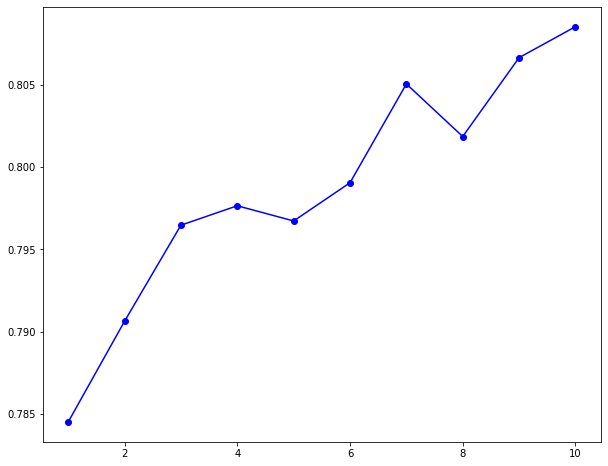

In [18]:
# Ploteamos el AVG por generacion
plt.figure(figsize=(10,8))
front = np.array([(c['gen'], c['avg']) for c in stats_records])
plt.plot(front[:,0][1:], front[:,1][1:], "-bo", c="b")
plt.axis("tight")
plt.show()